# Factorization

Factorization algorithms are useful for data-driven decomposition of spatial and temporal data, for example, to recover spatial patterns with similar temporal profiles. Here, we show how to use some of the factorization algorithms in Thunder and visualize the results.

Setup plotting
--------------

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')
from thunder import Colorize
image = Colorize.image

PCA
---
We start by performing PCA (principal component analysis), which finds patterns that capture most of the variance in the data. First load toy example data, and cache it to speed up repeated queries.


In [3]:
rawdata = tsc.loadExample('fish-series')
data = rawdata.toTimeSeries().normalize()
data.cache()
data.dims;

Run PCA with three components

In [4]:
from thunder import PCA
model = PCA(k=2).fit(data)

Fitting PCA adds two attributes to `model`: `comps`, which are the principal components, and `scores`, which are the data represented in principal component space. In this case, the input data were space-by-time, so the components are temporal basis functions, and the scores are spatial basis functions. Look at the results first by plotting the components, the temporal basis functions.

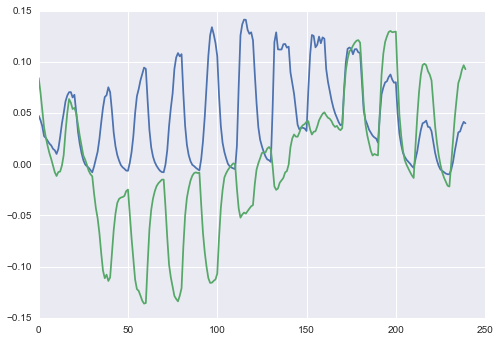

In [5]:
plt.plot(model.comps.T);

The scores are spatial basis functions. We can pack them into a local array and look at them as images one by one.

In [6]:
imgs = model.scores.pack()
imgs.shape

(2, 76, 87, 2)

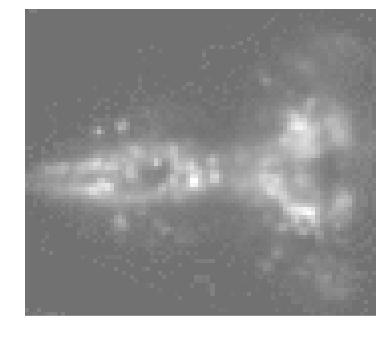

In [7]:
image(imgs[0,:,:,0], clim=(-0.05,0.05))

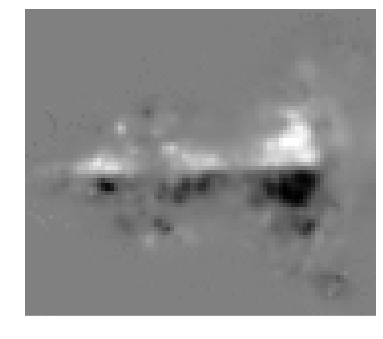

In [8]:
image(imgs[1,:,:,0], clim=(-0.05,0.05))

Clearly there is some spatial structure to each component, but looking at them one by one can be difficult. A useful trick is to look at two components at once via a color code that converts the scores into polar coordinates. The color (hue) shows the relative amount of the two components, and the brightness shows the total amplitude.

In [9]:
maps = Colorize(cmap='polar', scale=4).transform(imgs)

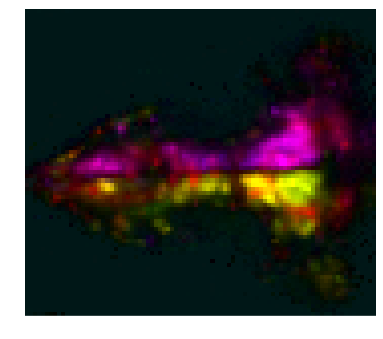

In [10]:
from numpy import amax
image(amax(maps,2))

To get more intuition for these colors, we can get the scores from a random subset of pixels. This will return two numbers per pixel, the projection onto the first and second principal component, and we threshold based on the norm so we are sure to retrieve pixels with at least some structure. Then we make a scatter plot of the two quantities against one another, using the same color conversion as used to generate the map.

In [11]:
pts = model.scores.subset(500, thresh=0.01, stat='norm')

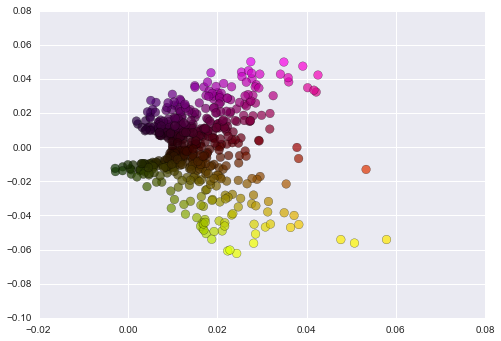

In [12]:
from numpy import newaxis, squeeze
clrs = Colorize(cmap='polar', scale=4).transform([pts[:,0][:,newaxis], pts[:,1][:,newaxis]]).squeeze()
plt.scatter(pts[:,0],pts[:,1], c=clrs, s=75, alpha=0.7);

Recall that each of these points represents a single pixel. Another way to better understand the PCA space is to plot the time series corresponding to each of these pixels, reconstructed using the first two principal components.

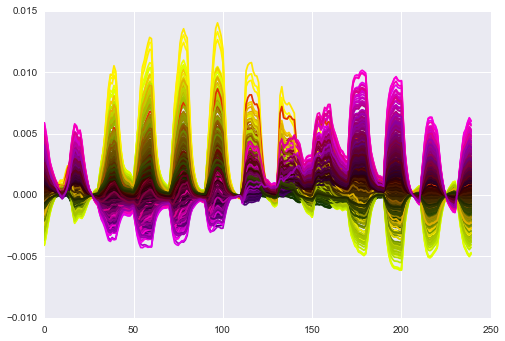

In [13]:
from numpy import asarray
recon = asarray(map(lambda x: (x[0] * model.comps[0, :] + x[1] * model.comps[1, :]).tolist(), pts))
plt.gca().set_color_cycle(clrs)
plt.plot(recon.T);

NMF
---
Non-negative matrix factorization is an alternative decomposition. It is meant to be applied to data that are strictly positive, which is often approximately true of neural responses. Like PCA, it also returns a set of temporal and spatial basis functions, but unlike PCA, it tends to return basis functions that do not mix responses from different regions together. We can run NMF on the same data and look at the basis functions it recovers.

In [14]:
from thunder import NMF
model = NMF(k=3, maxIter=20).fit(data)

After fitting, `model` will have two attributes, `h` and `w`. For these data, `h` contains the temporal basis functions, and `w` contains the spatial basis functions. Let's look at both.

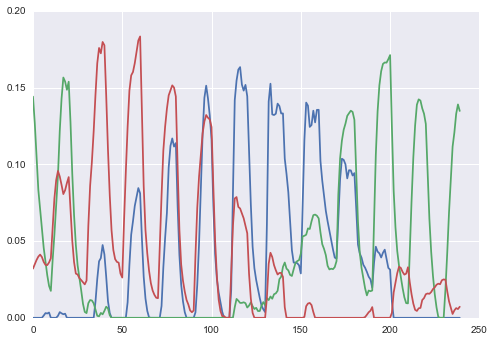

In [15]:
plt.plot(model.h.T);

In [16]:
imgs = model.w.pack()

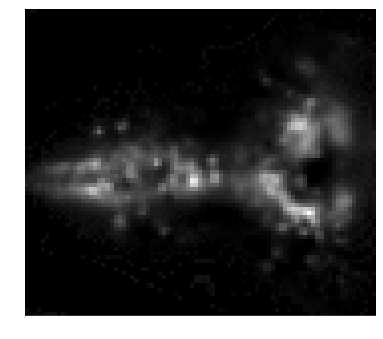

In [17]:
image(imgs[0][:,:,0])

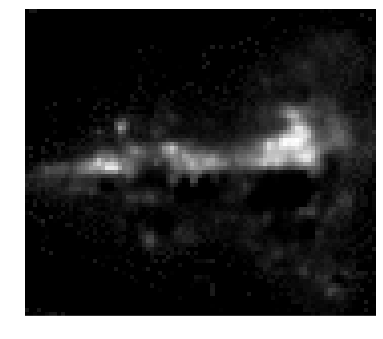

In [18]:
image(imgs[1][:,:,0])

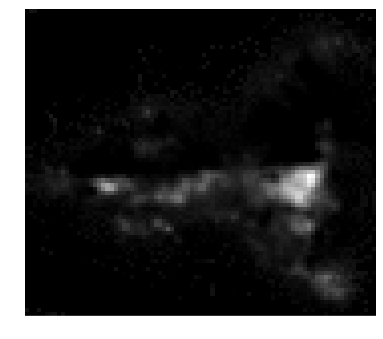

In [19]:
image(imgs[2][:,:,0])

For NMF, a useful way to look at the basis functions is to encode each one as a separate color channel. We can do that using colorization with an `rgb` conversion, which simply maps the spatial basis functions directly to red, green, and blue values, and applies a global scaling factor which controls overall brightness.

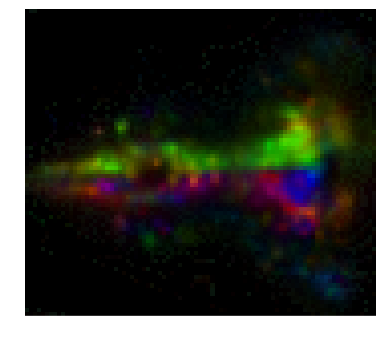

In [20]:
maps = Colorize(cmap='rgb', scale=1.0).transform(imgs)
image(maps[:,:,0,:])

One problem with this way to look at NMF components is that the scale of the different components can cause some to dominante others. We also might like more control over color assignments. The `indexed` colorization option lets you specify one color per channel, and automatically normalizes the amplitude of each one.

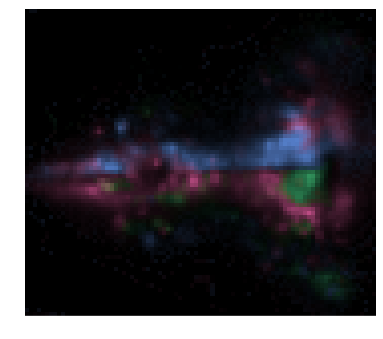

In [21]:
maps = Colorize(cmap='indexed', colors=[ "hotpink", "cornflowerblue", "mediumseagreen"], scale=1).transform(imgs)
image(maps[:,:,0,:])

With these plots, it can be useful to add in a background image (for example, the mean). In this case, we also show how to select and colorize just two of the three map components against a background.

In [22]:
ref = rawdata.seriesMean().pack()

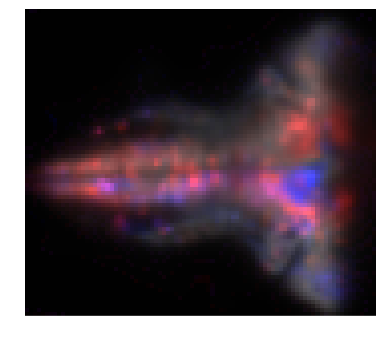

In [23]:
maps = Colorize(cmap='indexed', colors=['red', 'blue'], scale=1).transform(imgs[[0,2]], background=ref, mixing=0.5)
image(maps[:,:,0,:])

ICA
---
Independent component analysis is a final factorization approach. Unlike NMF, it does not require non-negative signals, but whereas PCA finds basis functions that maximize explained variance, ICA finds basis functions that maximize the non-Gaussianity of the recovered signals, and in practice, they tend to be both more distinct as well as spatially sparse.

In [24]:
from thunder import ICA
model = ICA(k=10,c=3).fit(data)

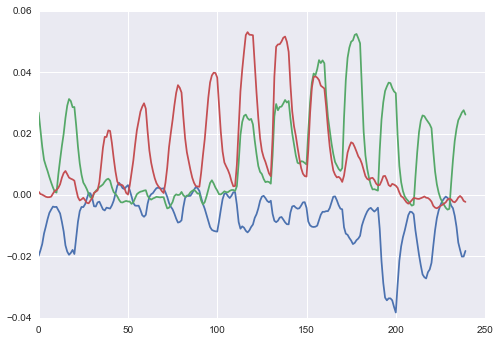

In [25]:
sns.set_style('darkgrid')
plt.plot(model.a);

Some signals will be positive and others negative. This is expected because sign is arbitrary in ICA. It is useful to look at absolute value when making maps.

In [26]:
imgs = model.sigs.pack()

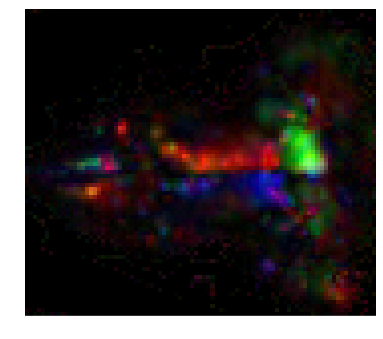

In [27]:
maps = Colorize(cmap='indexed', colors=['red','green', 'blue'], scale=3).transform(abs(imgs))
image(maps[:,:,0,:])